# In this week, We'll explore about Conv1D.

In [8]:
# Importing some vital libaries.
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Bidirectional, Lambda, LSTM
from tensorflow.keras.models import Sequential
import numpy as np

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
   
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
# lets create a window.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # predicting the ds.
    forecast = model.predict(ds)
    return forecast

About Conv1D, parameters
###### 1)filters: How many times you wanna do this operation.
###### 2) Kernel_size = How many units you wanna read at a time .
###### 3) strides = 1, skip by 1.
###### 4) padding must be causal.
###### 5) input_shape = [None, 1] . input can be of any length and we're dealing with univariate series, I'll mention 1.
###### 6) default activation funtion is None, which is Linear.
We are working in Conv1D, It will accept a individual values not a tuple.

In [12]:
window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
    Conv1D(filters = 32, kernel_size=5,
          strides=1, padding='causal',
          activation='relu',
          input_shape=[None, 1]),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dense(1),
    Lambda(lambda x:x * 200)
])

# taking the current epoch lr and doing some sort of operation on it
# then finally returing the lr.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
lambda epochs: 1e-8* 10**(epochs/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 16s 2s/step - loss: 41.4293 - mae: 41.9440
Epoch 2/100
8/8 [==============================] - 2s 210ms/step - loss: 40.2246 - mae: 40.7883
Epoch 3/100
8/8 [==============================] - 2s 207ms/step - loss: 38.3600 - mae: 38.9610
Epoch 4/100
8/8 [==============================] - 2s 269ms/step - loss: 36.2993 - mae: 36.7372
Epoch 5/100
8/8 [==============================] - 2s 295ms/step - loss: 33.6230 - mae: 34.2360
Epoch 6/100
8/8 [==============================] - 2s 216ms/step - loss: 30.9420 - mae: 31.5534
Epoch 7/100
8/8 [==============================] - 2s 196ms/step - loss: 28.2093 - mae: 28.7792
Epoch 8/100
8/8 [==============================] - 2s 238ms/step - loss: 25.4312 - mae: 26.0542
Epoch 9/100
8/8 [==============================] - 2s 284ms/step - loss: 22.9818 - mae: 23.5390
Epoch 10/100
8/8 [==============================] - 2s 216ms/step - loss: 20.8474 - mae: 21.4494
Epoch 11/100
8/8 [=======================

8/8 [==============================] - 1s 179ms/step - loss: 8.0918 - mae: 8.7607
Epoch 87/100
8/8 [==============================] - 2s 245ms/step - loss: 16.1664 - mae: 17.0182
Epoch 88/100
8/8 [==============================] - 2s 247ms/step - loss: 16.4825 - mae: 17.4360
Epoch 89/100
8/8 [==============================] - 1s 185ms/step - loss: 21.0110 - mae: 21.8688
Epoch 90/100
8/8 [==============================] - 1s 173ms/step - loss: 19.2343 - mae: 19.2085
Epoch 91/100
8/8 [==============================] - 2s 202ms/step - loss: 18.8072 - mae: 18.9108
Epoch 92/100
8/8 [==============================] - 3s 338ms/step - loss: 17.9455 - mae: 18.6551
Epoch 93/100
8/8 [==============================] - 2s 216ms/step - loss: 10.7619 - mae: 11.0683
Epoch 94/100
8/8 [==============================] - 1s 179ms/step - loss: 10.8167 - mae: 11.4419
Epoch 95/100
8/8 [==============================] - 1s 179ms/step - loss: 10.0650 - mae: 10.1701
Epoch 96/100
8/8 [===========================

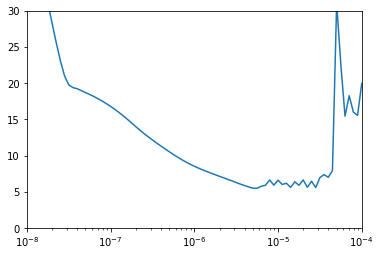

In [14]:
import matplotlib.pyplot as plt

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
    Conv1D(filters = 32, kernel_size=5,
          strides=1, padding='causal',
          activation='relu',
          input_shape=[None, 1]),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dense(1),
    Lambda(lambda x:x * 200)
])

# I'll change learning rate to 10^-5.
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(dataset, epochs=500, verbose=0)

In [16]:
# passing the model, in series we're passing dummy dimension and convert it
# it to new axis and the window_size.

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

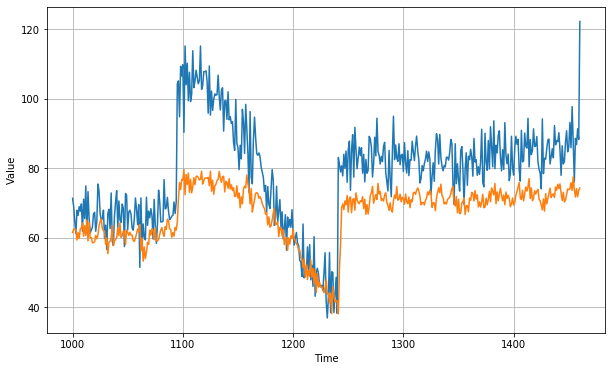

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Observe the  graph, x_valid is not matching with the rnn_forecast(they are predicted values).

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.792795

If you look at MAE, its worse.

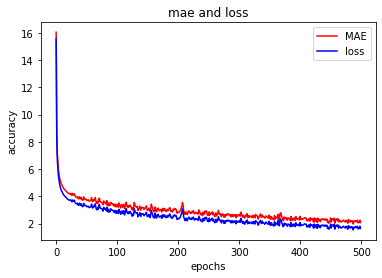

In [19]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title("mae and loss")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['MAE', 'loss'])

plt.show()

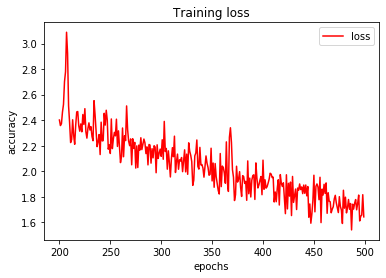

In [21]:
# lets see from 200 till end.
zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)

# plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(zoomed_epochs, zoomed_loss,'r')
plt.title('Training loss')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['loss'])

plt.show()